# **Installing and importing all necessary libraries**

In [1]:
#!pip install transformers pandas scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("instagram_english_reviews_sentiment.csv")
df.drop(columns = 'Unnamed: 0', inplace=True)
df

,content,score,sentiment
0,Great app for social media,1,Positive
1,Unable to log in An unexpected error occurred....,4,Negative
2,Please growth my channel,5,Positive
3,The bast app,5,Neutral
4,This is my favourite app,5,Neutral
...,...,...,...
55878,Its not cool tho,4,Negative
55879,not grow my post fastly,3,Neutral
55880,Instagram is the new Lifestyle exposure,5,Neutral
55881,this app very good,5,Positive


## **Exploratory Data Analysis (EDA)**

In [4]:
df.shape

(55883, 3)

In [5]:
df.dtypes

,0
content,object
score,int64
sentiment,object


In [6]:
df.isna().sum()

,0
content,0
score,0
sentiment,0


In [7]:
df.describe()

,score
count,55883.000000
mean,3.421917
std,1.761463
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


In [8]:
df.duplicated().sum()

0

<ipython-input-9-c195f378b20d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='score', data=df, palette = 'hls')


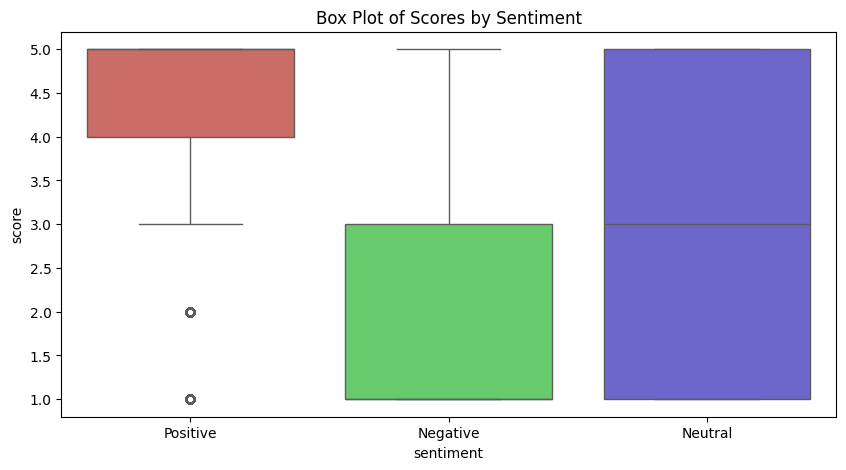

In [9]:
# Box Plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='score', data=df, palette = 'hls')
plt.title('Box Plot of Scores by Sentiment')
plt.show()

# **Data Visualization**

<ipython-input-10-6beb00d0b3cb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette = 'hls')


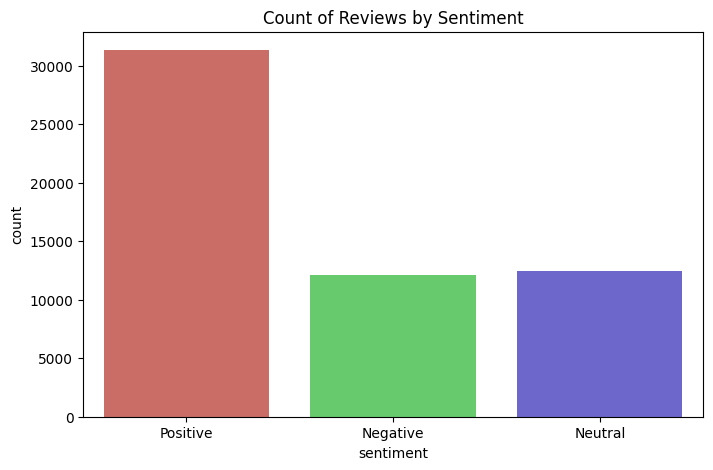

In [10]:
# Sentiment Count
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette = 'hls')
plt.title('Count of Reviews by Sentiment')
plt.show()

### **Word Cloud for each sentiment**

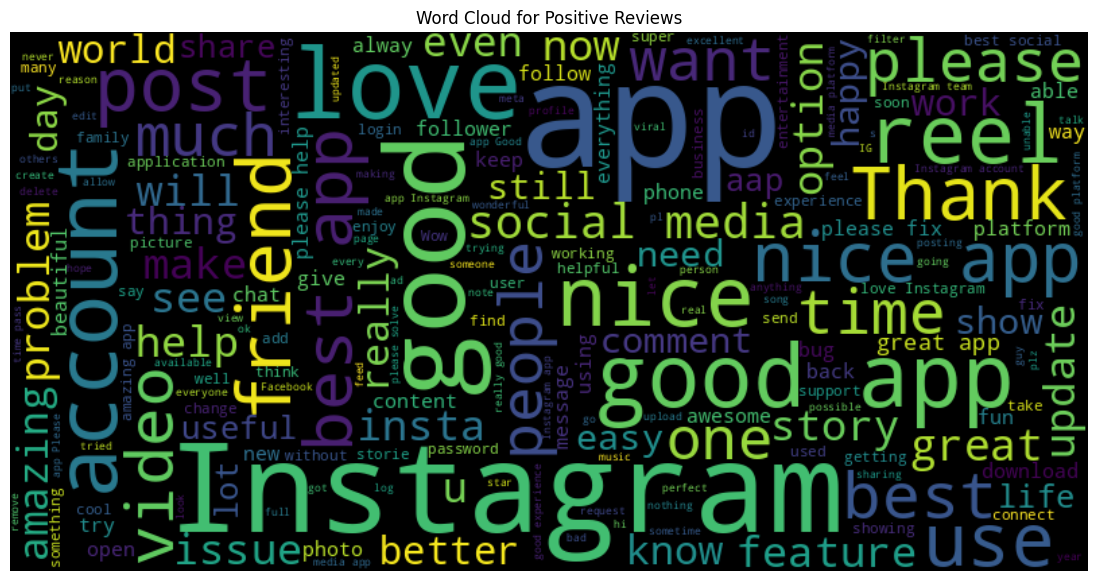

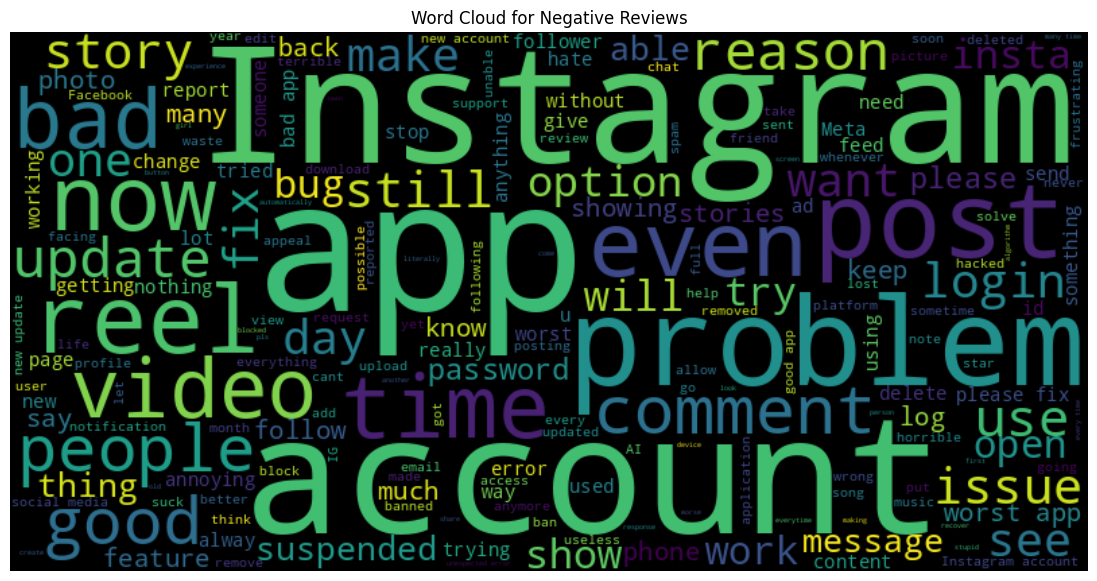

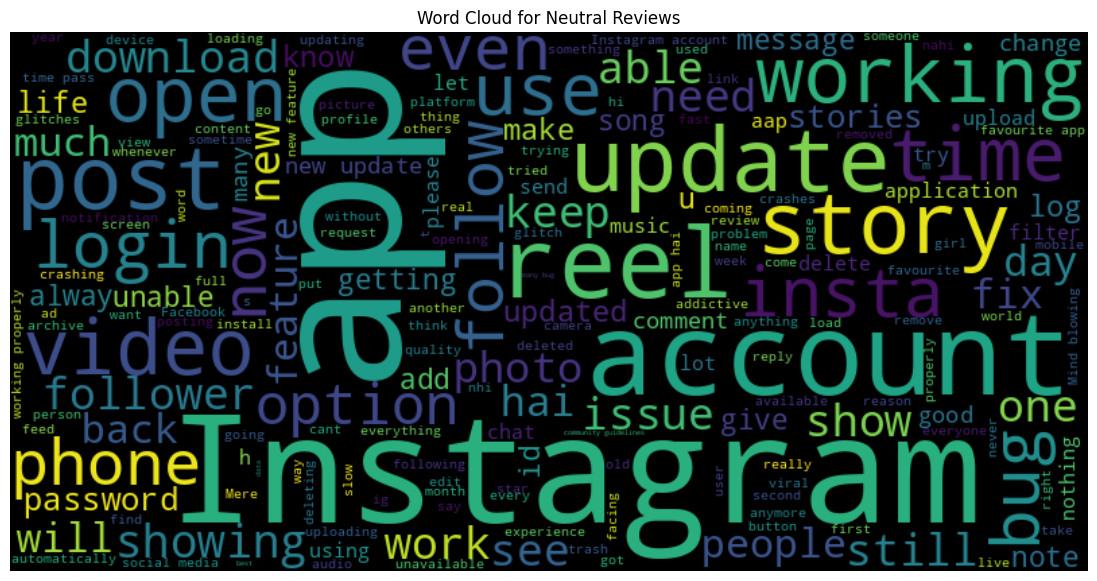

In [11]:
# Word Cloud for Sentiments
for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == sentiment]['content'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.show()

#       

## **Model Building**

**DistilBERT** is a smaller, faster, and lighter version of the BERT (Bidirectional Encoder Representations from Transformers) model, designed to maintain much of BERT's performance while being more efficient. Developed by Hugging Face, it employs a technique called knowledge distillation, where a smaller model (the student) learns from a larger model (the teacher) to achieve similar levels of accuracy with reduced computational requirements. As a result, DistilBERT is approximately 60% smaller, runs 2-3 times faster, and retains about 97% of BERT's language understanding capabilities. It is particularly useful for applications that require lower latency and reduced resource consumption while maintaining high performance in natural language processing tasks.


Key features of DistilBERT include:

1. **Reduced Size**: DistilBERT has about 40% fewer parameters than BERT, making it faster and more efficient for inference.

2. **Faster Training and Inference**: It requires less time to train and is quicker to run, making it suitable for applications with resource constraints.

3. **Retained Performance**: Despite its smaller size, DistilBERT achieves around 97% of BERT's performance on various NLP tasks, such as text classification and named entity recognition.

4. **Versatile Use**: Like BERT, DistilBERT can be fine-tuned for various natural language processing tasks.

Overall, DistilBERT is a great option for developers who need a balance between performance and resource efficiency.

In [12]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

# Define your sentiment mapping
sentiment_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
df['label'] = df['sentiment'].map(sentiment_mapping)
df

,content,score,sentiment,label
0,Great app for social media,1,Positive,2
1,Unable to log in An unexpected error occurred....,4,Negative,0
2,Please growth my channel,5,Positive,2
3,The bast app,5,Neutral,1
4,This is my favourite app,5,Neutral,1
...,...,...,...,...
55878,Its not cool tho,4,Negative,0
55879,not grow my post fastly,3,Neutral,1
55880,Instagram is the new Lifestyle exposure,5,Neutral,1
55881,this app very good,5,Positive,2


## **Data Partition (80:20)**

In [13]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Check the shapes of the splits
print("Training texts shape:", len(train_texts))
print("Validation texts shape:", len(val_texts))
print("Training labels shape:", len(train_labels))
print("Validation labels shape:", len(val_labels))

Training texts shape: 44706
Validation texts shape: 11177
Training labels shape: 44706
Validation labels shape: 11177


### **Loading DistilBERT Model and Tokenizer**

In [14]:
# Load tokenizer and model for DistilBERT
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distilbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Text Tokenization and Encoding**

In [15]:
# Tokenization
train_encodings = tokenizer_distilbert(train_texts, truncation=True, padding=True)
val_encodings = tokenizer_distilbert(val_texts, truncation=True, padding=True)

In [16]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### **Creating Training and Validation Datasets**

In [17]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [18]:
train_dataset[0]

{'input_ids': tensor([  101,  2026, 16021, 23091,  2003,  2025,  3098, 20228,  2015,  9611,
          1996,  3291,  3435,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [19]:
# Define the compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)  # Get the predicted class
    return {'accuracy': accuracy_score(p.label_ids, preds)}

### **Configuring Training Arguments and Creating the Trainer**

In [20]:
# Set up training arguments with evaluation every 1500 steps
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="steps",
    eval_steps=1500,  # Evaluate every 1500 steps
    save_steps=500,   # Save model every 500 steps
    logging_steps=500, # Log every 500 steps
)

# Create a Trainer instance
trainer = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Pass the compute_metrics function
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### **Model Training**

In [21]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
1500,0.255400,0.241370,0.922072
3000,0.173200,0.209674,0.942113
4500,0.131100,0.197041,0.947392
6000,0.085800,0.211106,0.954281
7500,0.085200,0.196986,0.955713


TrainOutput(global_step=8385, training_loss=0.17069266858951065, metrics={'train_runtime': 4065.6582, 'train_samples_per_second': 32.988, 'train_steps_per_second': 2.062, 'total_flos': 7772878491444864.0, 'train_loss': 0.17069266858951065, 'epoch': 3.0})

### **Evaluating the Model**

In [22]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.18873293697834015,
 'eval_accuracy': 0.9560705019235931,
 'eval_runtime': 195.1539,
 'eval_samples_per_second': 57.273,
 'eval_steps_per_second': 3.582,
 'epoch': 3.0}

### **Saving & downloading the model**

In [23]:
# Save the model and tokenizer
trainer.save_model('./distilbert_model')
tokenizer_distilbert.save_pretrained('./distilbert_model')

('./distilbert_model/tokenizer_config.json',
 './distilbert_model/special_tokens_map.json',
 './distilbert_model/vocab.txt',
 './distilbert_model/added_tokens.json')

In [24]:
!zip -r distilbert_model.zip ./distilbert_model

  adding: distilbert_model/ (stored 0%)
  adding: distilbert_model/model.safetensors (deflated 8%)
  adding: distilbert_model/tokenizer_config.json (deflated 75%)
  adding: distilbert_model/training_args.bin (deflated 51%)
  adding: distilbert_model/vocab.txt (deflated 53%)
  adding: distilbert_model/config.json (deflated 49%)
  adding: distilbert_model/special_tokens_map.json (deflated 42%)


In [25]:
from google.colab import files
files.download('distilbert_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>